In [156]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
from tqdm.notebook import tqdm 
from TDA_utils import cvb
from scipy.signal import spectrogram
import h5py
#%matplotlib widget

In [2]:
datapath ="./dane vibstand/"
filelist = os.listdir(datapath)
print(sorted(filelist))
filenames  =sorted(filelist)
df_list = []
for filename in sorted(filelist):
    f = h5py.File(datapath +filename,'r')
    data_names = np.array(f.get('/'))
    dictionary = {}
    for i in range(0,len(data_names)-1):
        name = data_names[i]
        dictionary.update({name : np.array(f.get('/'+name)).T[0]})
    df = pd.DataFrame.from_dict(dictionary)
    df_list.append(df)

['speed_10.mat', 'speed_15.mat', 'speed_20.mat', 'speed_25_5.mat']


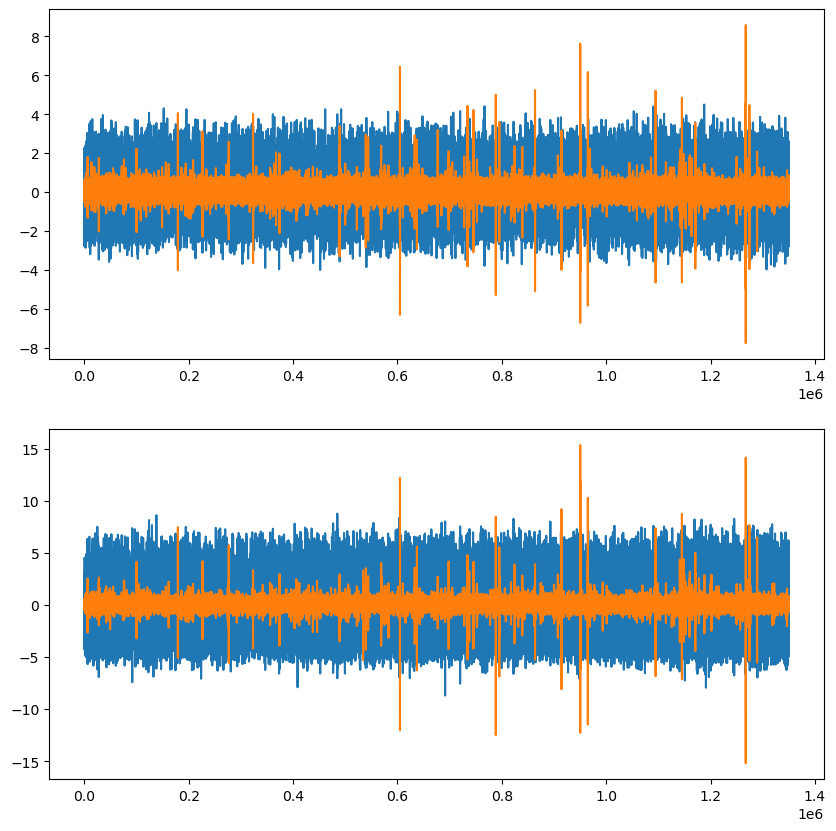

In [3]:
df = df_list[3]
f,ax = plt.subplots(2,1, figsize =(10,10))
ax[0].plot(df["Vib1"])
ax[0].plot(df["Vib3"])
ax[1].plot(df["Vib2"])
ax[1].plot(df["Vib4"])
plt.show()

In [4]:
def compute_diagram(data, dim, delay, skip, normalize = True, weighted = True, point_cloud_size = 100):
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform([data])[0]
    if len(point_clouds>250):
        skip = max(len(point_clouds)//250,1)
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform([data])[0] 
    #point_clouds = levy_stable.rvs(alpha,0,0, size=(100,2))

    if (normalize):
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]

    pc = point_clouds
    #print(len(pc))

    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)
    
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    return pd

In [162]:
n_samples = 10
norms = np.zeros((4,4,n_samples))
start = 2.98
end = 3.7
grid = np.linspace(start,end,257)
bc = BettiCurve(predefined_grid=grid)
betti_curves = np.zeros((4,4,n_samples,len(grid)))

speeds = [10,15,20,25]


for j in tqdm(range(0,len(df_list))):
    scaling_factor =(j+2)*0.5    
    dim = int(90*(1/(scaling_factor)))
    delay = 120#int(60*(1/(scaling_factor)**2))#int(90*scaling_factor)
    
    print("Speed {}, dim = {}, delay = {}".format(speeds[j],dim,delay))
    
    skip =1
    for i in range(0,4):
        samples = np.array_split(df_list[j].iloc[:,i].values,n_samples)
        
        for k in range(0,len(samples)):
            pd = compute_diagram(samples[k], dim, delay, skip, normalize = True, weighted = True, point_cloud_size = 250)
            #bc = np.array(compute_bc_from_ts(samples[k], dim, delay, skip))
            curve = np.array(bc.fit_transform([pd])[0])
            betti_curves[j,i,k] = curve
            #norm = compute_norms_from_ts(samples[k], dim, delay, skip)
            norm = wasserstein_distance(pd,[], order=1, internal_p = 1)
            
            norms[j,i,k] = norm

  0%|          | 0/4 [00:00<?, ?it/s]

Speed 10, dim = 90, delay = 120
Speed 15, dim = 60, delay = 120
Speed 20, dim = 45, delay = 120
Speed 25, dim = 36, delay = 120


In [157]:
#cvb

n_samples = 10
cvb_curves = np.zeros((4,4,n_samples,257))




for j in tqdm(range(0,len(df_list))):

    for i in range(0,4):
        samples = np.array_split(df_list[j].iloc[:,i].values,n_samples)
        
        for k in range(0,len(samples)):
            freqs, t, Pxx = spectrogram(samples[k], fs=25000, nfft=512, window="hamming", nperseg= 256, noverlap= int(np.floor(0.85*256)),detrend = False, mode="magnitude")
            curve =  np.array([cvb(np.abs(Pxx[i])) for i in range(0,len(freqs))])

            cvb_curves[j,i,k] = curve

  0%|          | 0/4 [00:00<?, ?it/s]

Speed 10, dim = 90, delay = 120
Speed 15, dim = 60, delay = 120
Speed 20, dim = 45, delay = 120
Speed 25, dim = 36, delay = 120


In [163]:
curves = np.concatenate([betti_curves, (np.max(betti_curves)/np.max(cvb_curves))*cvb_curves],axis = 3)
curves.shape

(4, 4, 10, 514)

  0%|          | 0/4 [00:00<?, ?it/s]

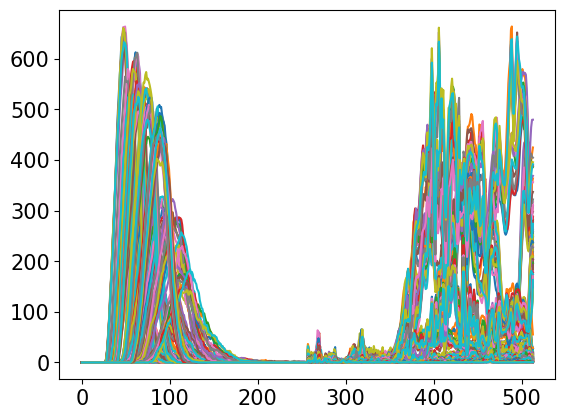

In [164]:
f,ax = plt.subplots()
for j in tqdm(range(0,len(df_list))):
    for i in range(0,4):
        for k in range(0,len(samples)):
            ax.plot(curves[j,i,k])
plt.show()

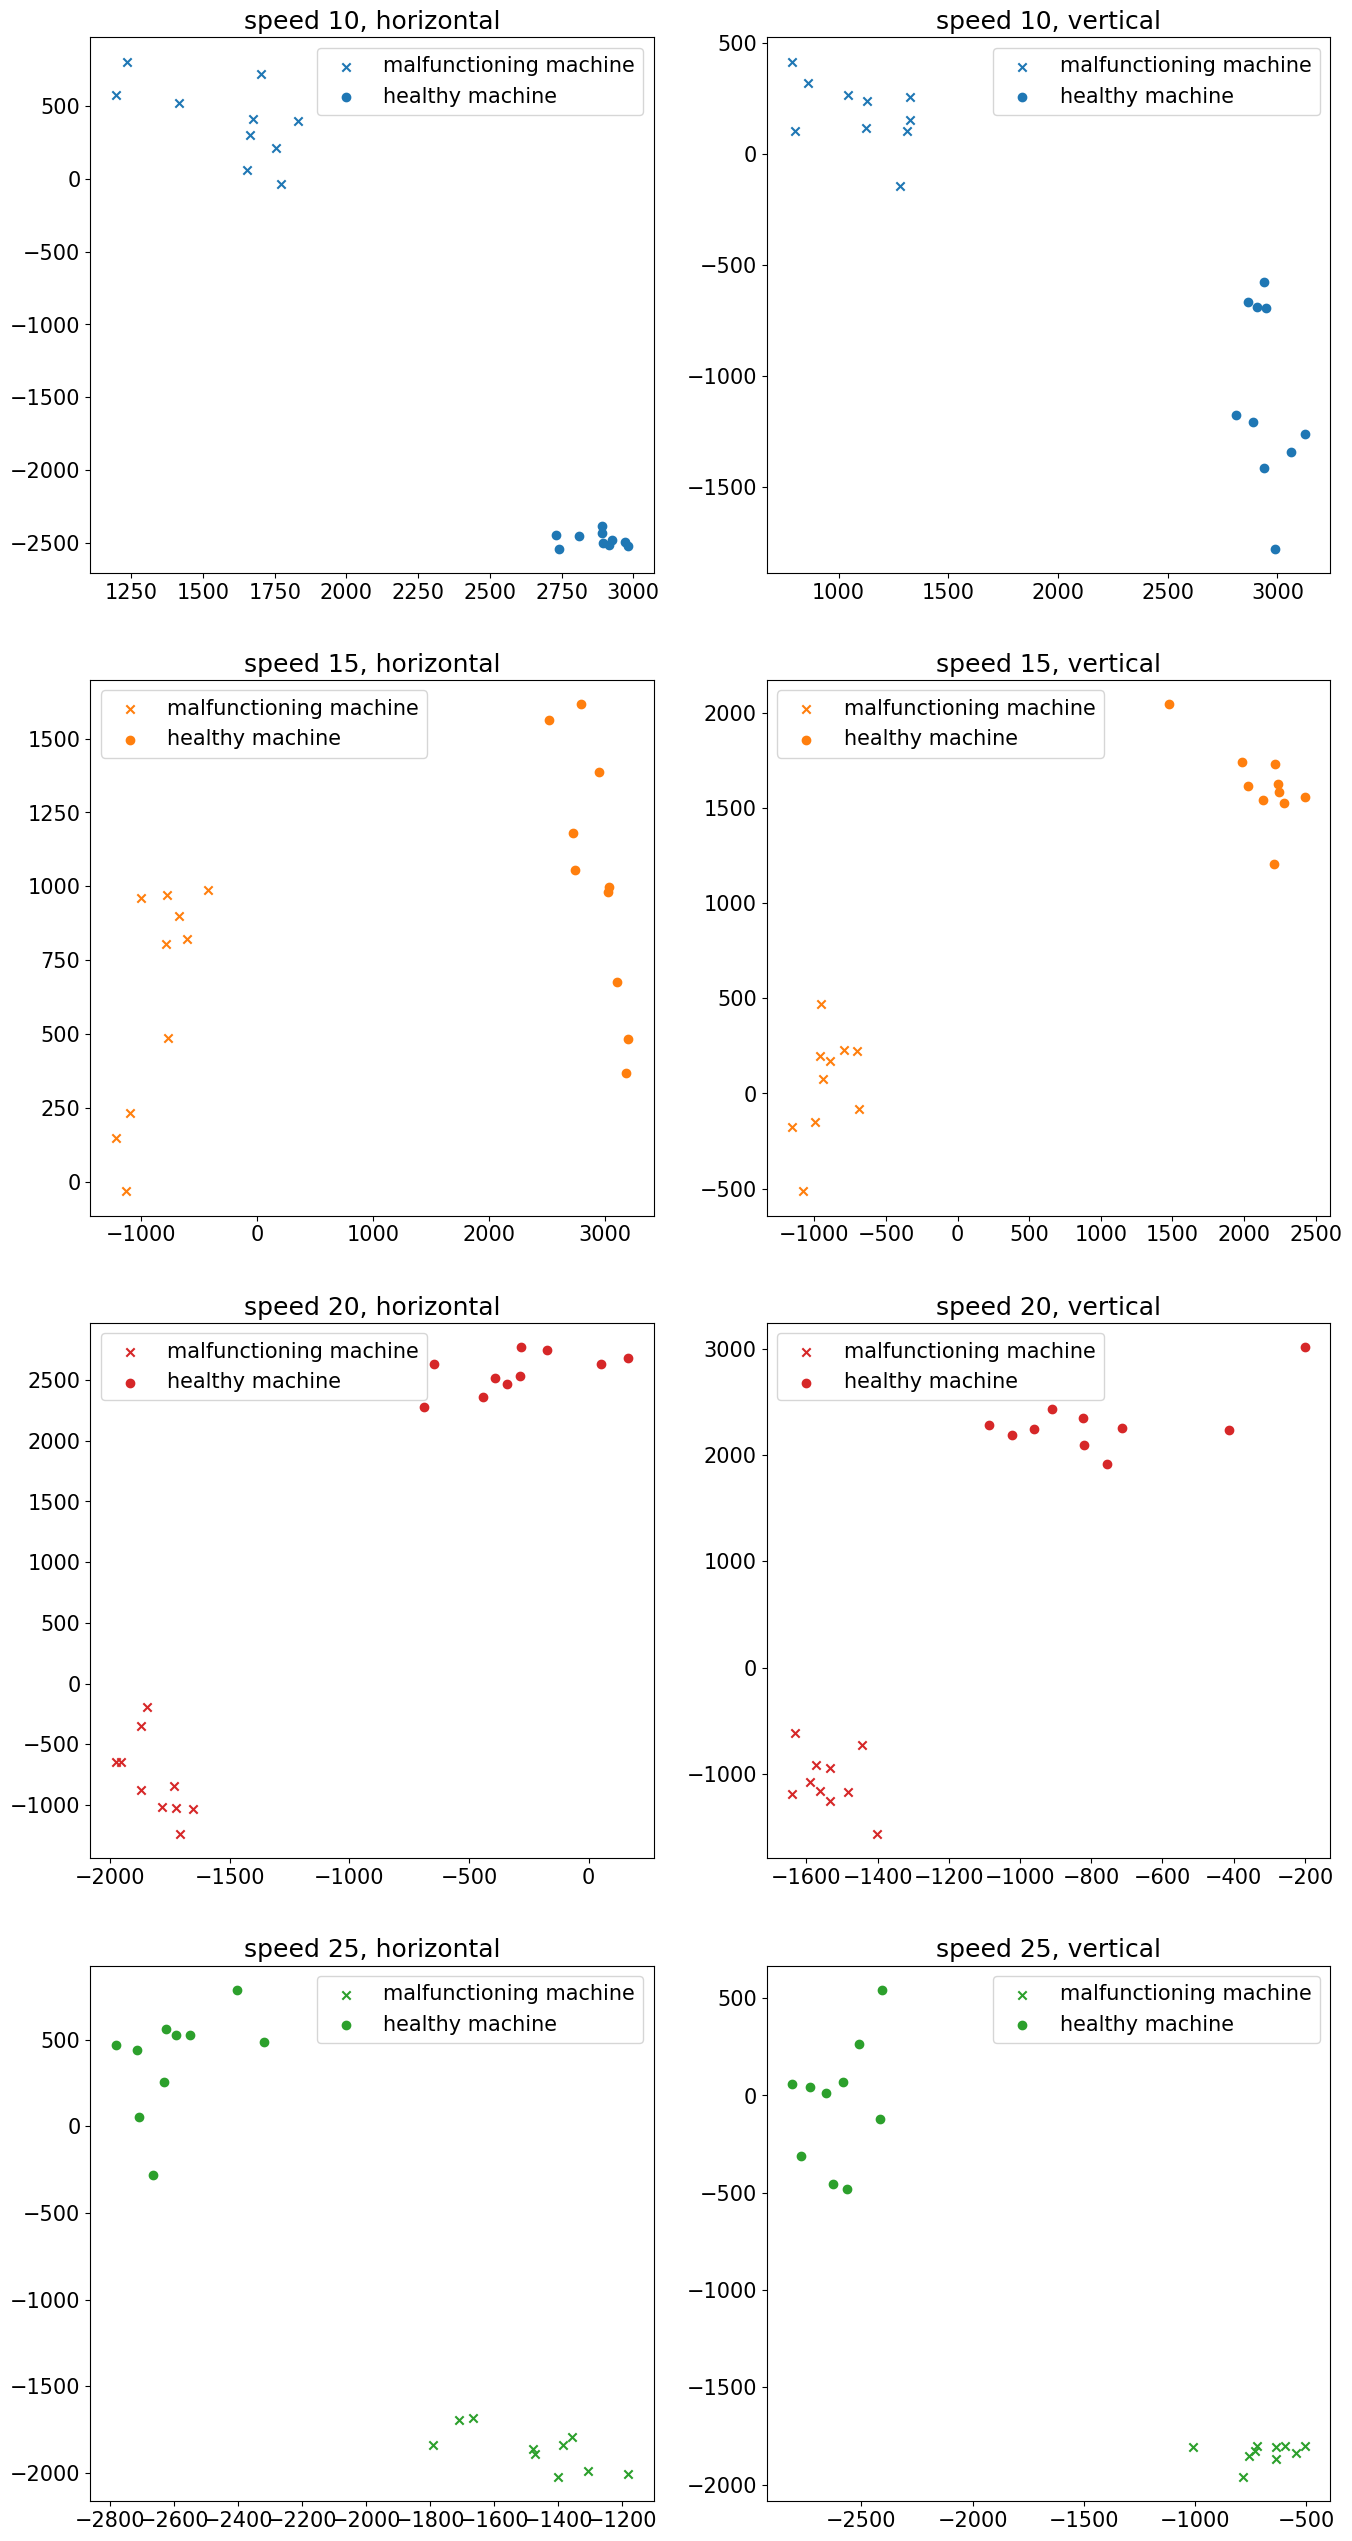

[0.52234246 0.29728997 0.10676923]


In [141]:
pca = PCA(n_components=3)
pca.fit_transform([betti_curves[j,i,k] for j in range(0,4) for i in range(0,4) for k in range(0,n_samples)])

fig,ax = plt.subplots(4,2,figsize=(16,32))
#ax.scatter(emb[:,0],emb[:,1])#,  marker = "o", c=t, label="malfunctioning machine {}".format(i))
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    emb_bad_h = pca.transform(betti_curves[i,0,:])
    emb_good_h = pca.transform(betti_curves[i,2,:])
    ax[i,0].scatter(emb_bad_h[:,0],emb_bad_h[:,1], marker = "x", c=colors[i], label="malfunctioning machine")
    ax[i,0].scatter(emb_good_h[:,0],emb_good_h[:,1], marker = "o", c=colors[i], label="healthy machine")
    ax[i,0].set_title("speed {}, horizontal".format(speeds[i]))
    ax[i,0].legend()
    emb_bad_v = pca.transform(betti_curves[i,1,:])
    emb_good_v = pca.transform(betti_curves[i,3,:])
    ax[i,1].scatter(emb_bad_v[:,0],emb_bad_v[:,1], marker = "x", c=colors[i], label="malfunctioning machine")
    ax[i,1].scatter(emb_good_v[:,0],emb_good_v[:,1], marker = "o", c=colors[i], label="healthy machine")
    ax[i,1].set_title("speed {}, vertical".format(speeds[i]))
    ax[i,1].legend()


plt.show()
print(pca.explained_variance_ratio_)

speed 10, horizontal: malfunctioning avg l2 norm = 25.28186667695041, std = 1.2426432205227294
speed 10, horizontal: helathy avg l2 norm = 32.992101228115544, std = 0.7991645999135464
speed 10, vertical: malfunctioning avg l2 norm = 21.89867864731433, std = 0.8584908056903078
speed 10, vertical: helathy avg l2 norm = 29.513385777991846, std = 1.0278034822929945
speed 15, horizontal: malfunctioning avg l2 norm = 26.175408596813476, std = 1.765762193710922
speed 15, horizontal: helathy avg l2 norm = 36.21652860677887, std = 1.2806281421594314
speed 15, vertical: malfunctioning avg l2 norm = 22.41143757676904, std = 1.725826128205976
speed 15, vertical: helathy avg l2 norm = 34.281059011359005, std = 1.058091106081459
speed 20, horizontal: malfunctioning avg l2 norm = 28.365553281720235, std = 1.4987011289096217
speed 20, horizontal: helathy avg l2 norm = 37.90347496475156, std = 1.0572198234400103
speed 20, vertical: malfunctioning avg l2 norm = 24.954263632469086, std = 1.18294614668651

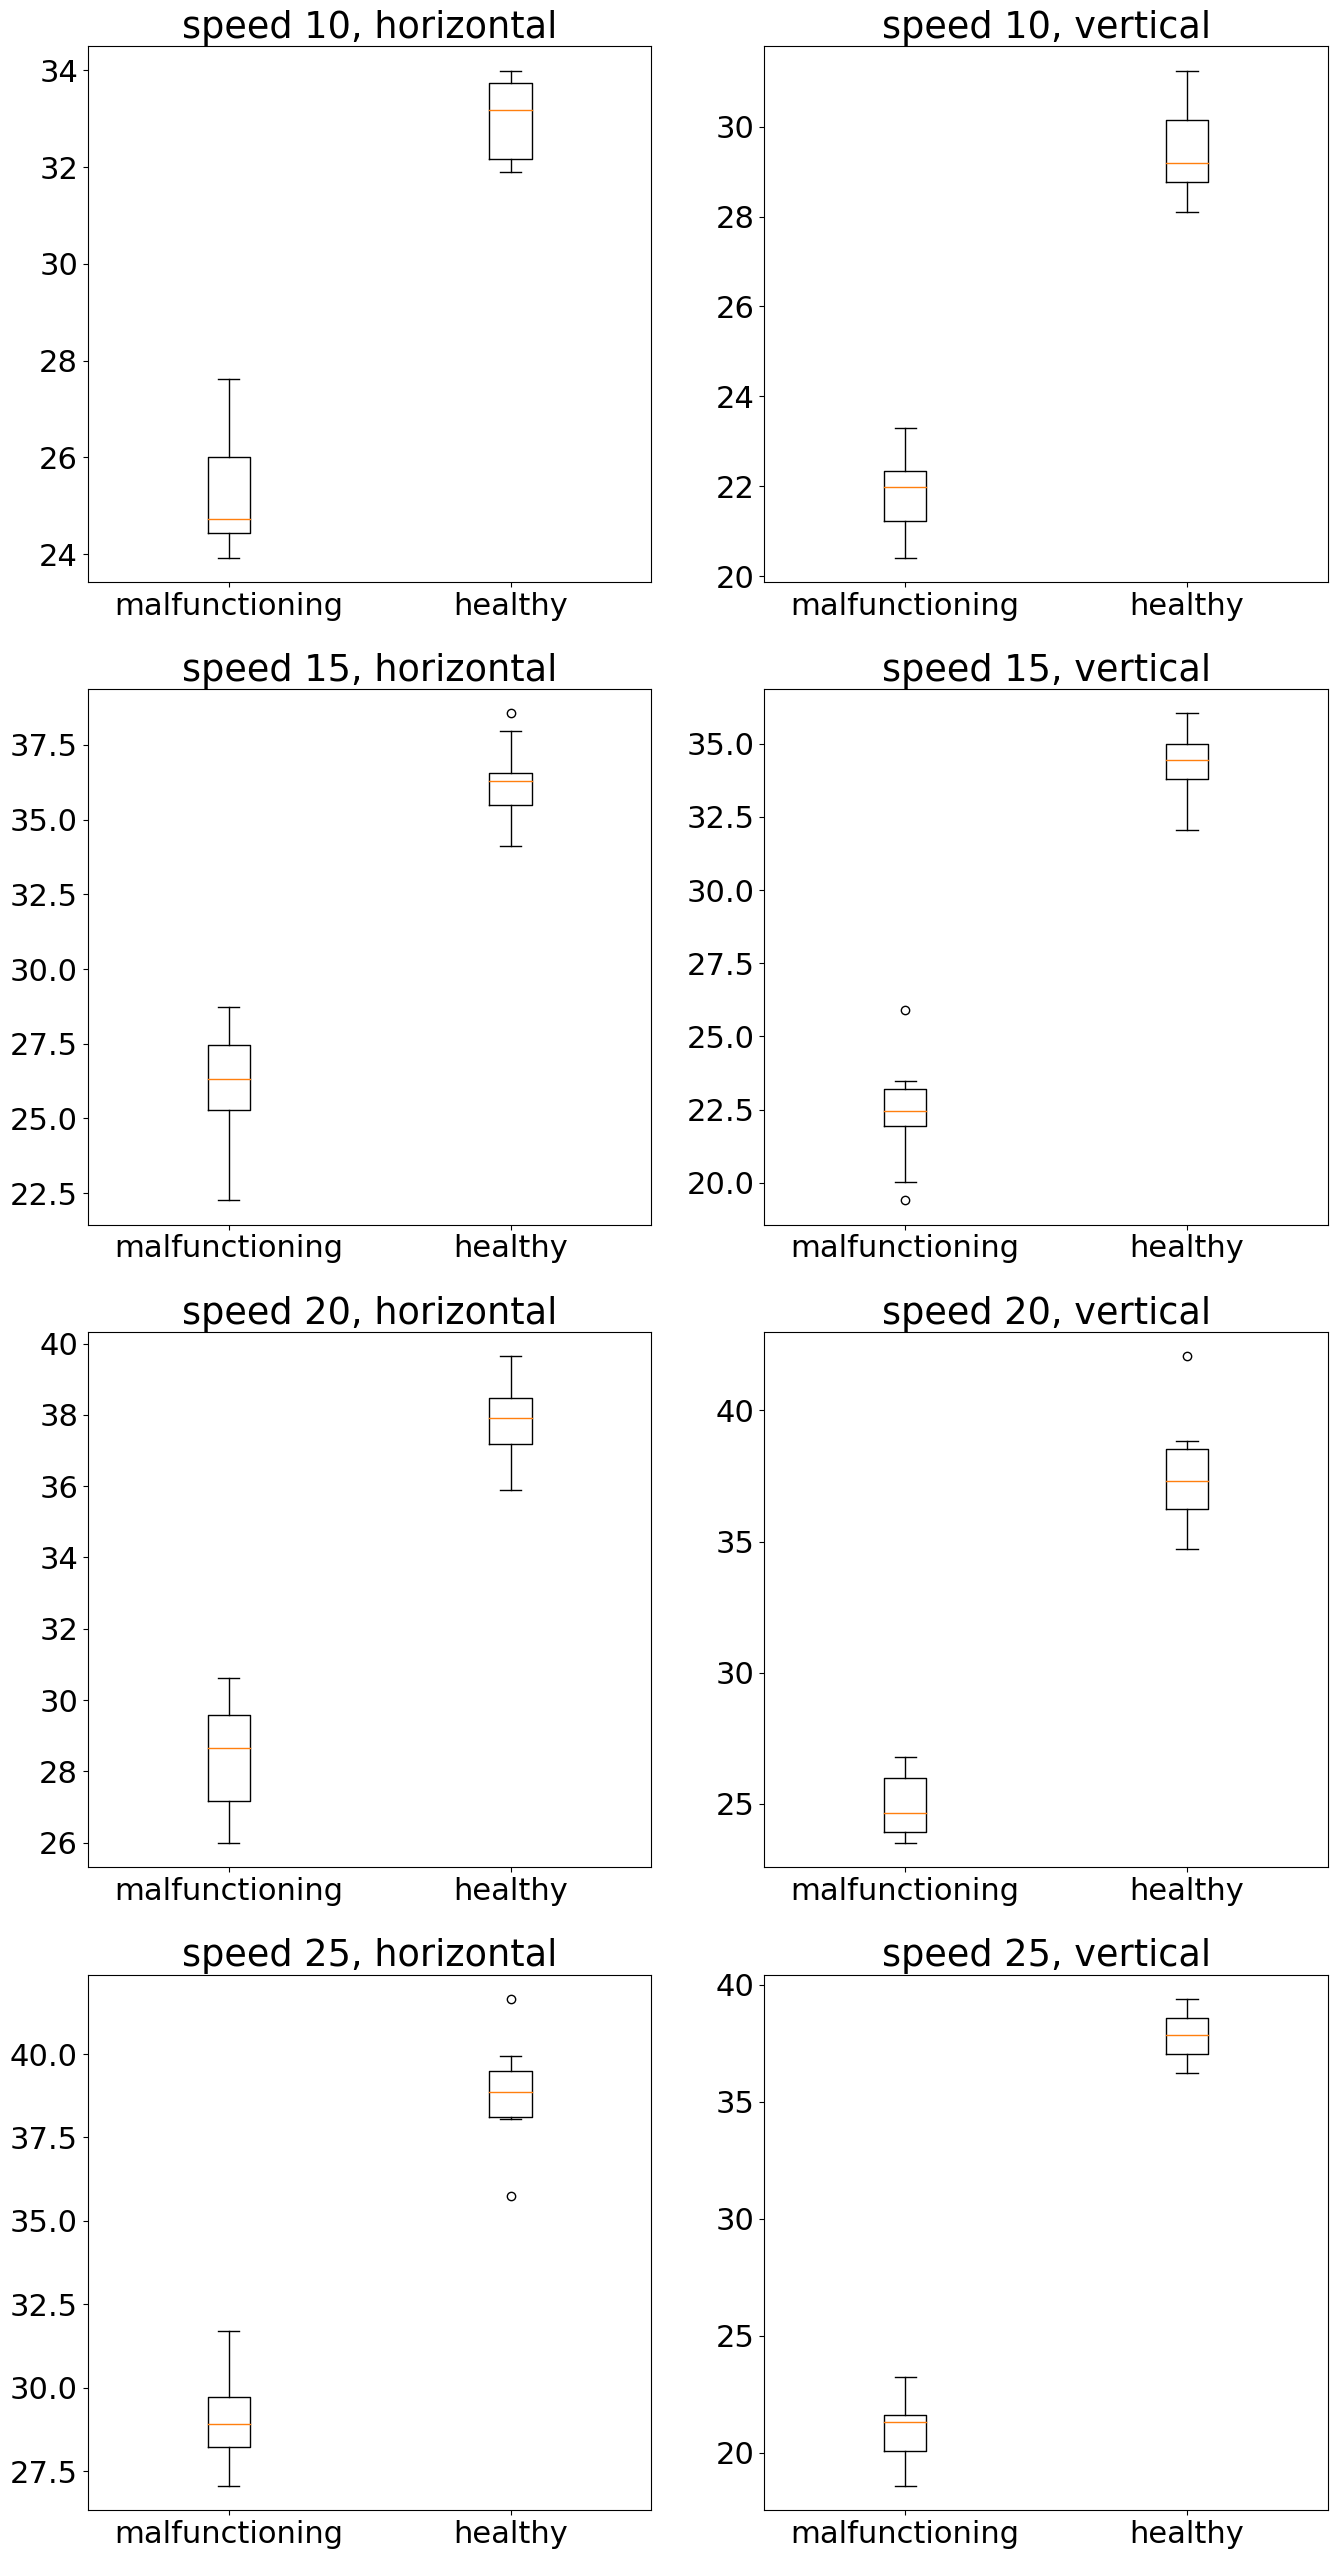

In [142]:
plt.rc('font', **{'size'   : 22})

fig,ax = plt.subplots(4,2,figsize=(16,32))

##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    ax[i,0].boxplot([norms[i,0,:],norms[i,2,:]])
    ax[i,0].set_title("speed {}, horizontal".format(speeds[i]))
    ax[i,0].set_xticklabels(["malfunctioning", "healthy"])
    
    ax[i,1].boxplot([norms[i,1,:],norms[i,3,:]])
    ax[i,1].set_title("speed {}, vertical".format(speeds[i]))
    ax[i,1].set_xticklabels(["malfunctioning", "healthy"])

    print("speed {}, horizontal: malfunctioning avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,0,:]), np.std(norms[i,0,:]) ))
    print("speed {}, horizontal: helathy avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,2,:]), np.std(norms[i,2,:]) ))
    print("speed {}, vertical: malfunctioning avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,1,:]), np.std(norms[i,1,:]) ))
    print("speed {}, vertical: helathy avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,3,:]), np.std(norms[i,3,:]) ))
          
          
#fig.suptitle("L1 norms")
plt.savefig("vibstand_results/TestRigBoxplot.pdf")

plt.show()

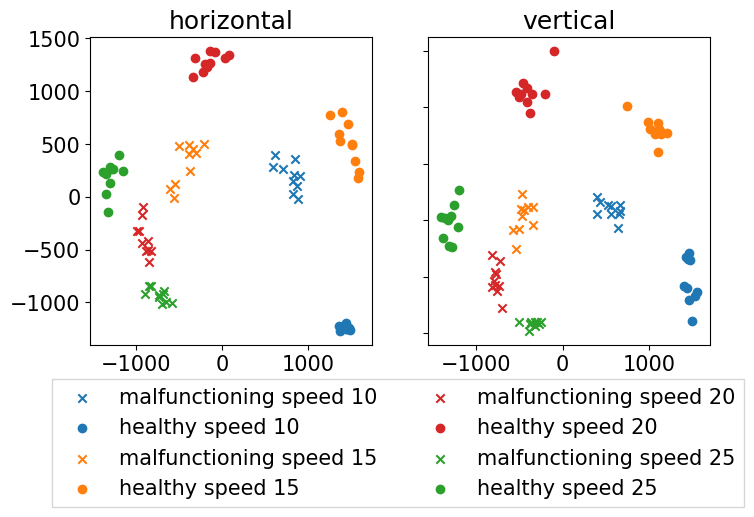

In [165]:
pca = PCA(n_components=3)
pca.fit_transform([betti_curves[j,i,k] for j in range(0,4) for i in range(0,4) for k in range(0,n_samples)])
plt.rc('font', **{'size'   : 15})

fig,ax = plt.subplots(1,2,figsize=(8,4))
#ax.scatter(emb[:,0],emb[:,1])#,  marker = "o", c=t, label="malfunctioning machine {}".format(i))
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    emb_bad_h = pca.transform(betti_curves[i,0,:])
    emb_good_h = pca.transform(betti_curves[i,2,:])
    ax[0].scatter(emb_bad_h[:,0],emb_bad_h[:,1], marker = "x", c=colors[i], label="malfunctioning speed {}".format(speeds[i]))
    ax[0].scatter(emb_good_h[:,0],emb_good_h[:,1], marker = "o", c=colors[i], label="healthy speed {}" .format(speeds[i]))
    ax[0].set_title("horizontal")
    emb_bad_v = pca.transform(betti_curves[i,1,:])
    emb_good_v = pca.transform(betti_curves[i,3,:])
    ax[1].scatter(emb_bad_v[:,0],emb_bad_v[:,1], marker = "x", c=colors[i], label="malfunctioning machine {}".format(speeds[i]))
    ax[1].scatter(emb_good_v[:,0],emb_good_v[:,1], marker = "o", c=colors[i], label="healthy machine {}".format(speeds[i]))
    ax[1].set_title("vertical")

#ax[0].legend()
#ax[1].legend(prop = {"size":24})
ax[1].set_yticklabels([])
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.51, 0.05),
          fancybox=False, shadow=False, ncols=2, prop={"size":15})

#fig.suptitle("PCA from Betti Curves, explained variance:{}".format(pca.explained_variance_ratio_))
plt.savefig("vibstand_results/TestRigPCA.pdf", bbox_inches="tight")

plt.show()

#print()

In [170]:
def split_score(X,y, test_size, seed):
    clf = SVC(kernel="linear")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)
    #print(y_train.sum(), y_test.sum())
    clf.fit(X_train, y_train)
    return np.array([clf.score(X_test, y_test), np.linalg.norm(clf.coef_[0])])

#SVM classification
n_iterations = 100
score_list = []
svnorm_list = []
for j in range(len(speeds)):
    X=np.array([cvb_curves[j,i,k] for i in range(0,4) for k in range(0,n_samples)])
    y = np.repeat([0,1], 2*n_samples)
    results = Parallel(n_jobs=-1)(delayed(split_score)(X,y, 0.5, i) for i in range(n_iterations))
    results = np.array(results).T
    local_score_list = results[0]
    local_svnorm_list = results[1]
    
    score_list.append(np.array(local_score_list))
    svnorm_list.append(np.array(local_svnorm_list))


1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


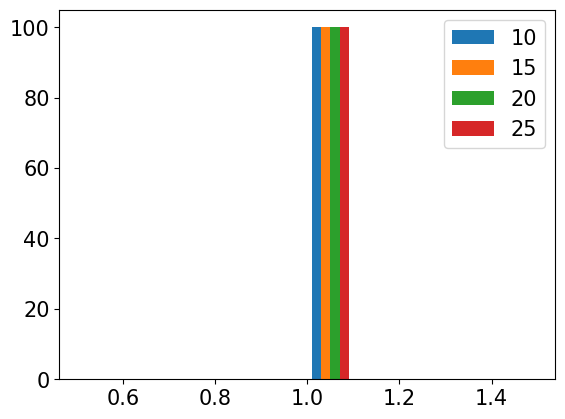

In [171]:
plt.hist(score_list, label=speeds)
plt.legend()
for i in range(len(score_list)):
    print(np.mean(score_list[i]),np.std(score_list[i]))

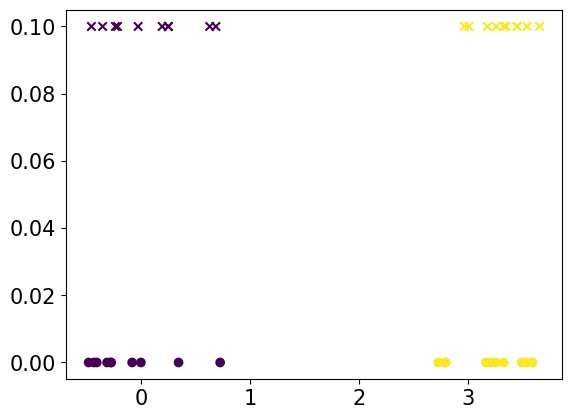

In [149]:
f,ax = plt.subplots()
projection = np.dot(X_train, clf.coef_[0])
ax.scatter(projection, [0]*20, c=y_train)
projection = np.dot(X_test, clf.coef_[0])
ax.scatter(projection, [0.1]*20, c=y_test, marker="x")


plt.show()